# Plain bayesian UCB is not enough <a id="top"></a>

Out of habit, I copied most algorithms from the public notebooks, submitted them, and found that the best public algorithm was the **bayesian upper confidence bound (UCB) algorithm**. However, I have only been able to yield ~900 points on the leaderboard with bayesian UCB and was wondering why it doesn't break the 1000 point barrier.

A rather simple sample code for bayesian UCB is given in: https://www.kaggle.com/xhlulu/santa-2020-ucb-and-bayesian-ucb-starter

In this notebook, I will show that the bayesian UCB agent performs well if the decay rate is 1 but performs poorly for the default decay rate of 0.97.

**Table of contents**
- [Brief explanation of multi-armed bandit (MAB) problem](#explain) (Skip this if you are aware of the MAB problem)
- [Bayesian UCB algorithm](#bayes_ucb)
- [Exploring the Kaggle environment](#explore) (Skip this if you are aware of the specifications of the kaggle environment)
- [Bayesian UCB agent against random agent with decay rate = 1](#no_decay)
- [Bayesian UCB agent against random agent with decay rate = 0.97](#with_decay)

In [ ]:
!pip install --upgrade kaggle_environments -q

In [ ]:
import kaggle_environments
kaggle_environments.__version__

In [ ]:
import numpy as np
import math
import random
import os
from scipy.stats import beta
import matplotlib.pyplot as plt

from kaggle_environments import make

In [ ]:
random.seed(2020)

# Brief explanation of multi-armed bandit (MAB) problem <a id="explain"></a>

If you prefer a more detailed explanation of the MAB problem check out:
- Classical reinforcement learning textbook: https://www.andrew.cmu.edu/course/10-703/textbook/BartoSutton.pdf (pages 27 - 47)
- https://www.davidsilver.uk/wp-content/uploads/2020/03/XX.pdf

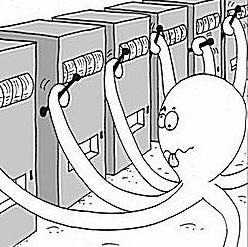

**Scenario**:
Imagine there are 100 slot machines and at any one time only a single lever can be pulled once. After the lever is pulled, the corresponding slot machine either generates a reward of value 1 or 0. Each machine $i$, where $i=1,\ldots,100$, has a probability $p_i$ of generating a reward which is unknown to us.

**Goal**:
The goal here is to devise a strategy to pull the levers to maximise the rewards gained after 2000 lever pulls.

**Bayesian UCB Strategy**: Try to create a good upper bound for the unknown probabilities $p_i$ using bayesian statistics after exploring the various slot machines. Then consistently pull the lever with the highest _estimated_ probability of generating a reward, i.e. highest $p_i$.

**Problem**:
The above is the classical MAB problem and bayesian UCB solution described in most literature, however there's a catch in this Kaggle environment.

In this competition, whenever a lever is pulled, the unknown reward probability of the pulled lever decays by the factor of 0.97 by default. Also, we're playing with an opponent who is also pulling the levers.

Say suppose the initial unknown reward probability is 0.9, then I pulled the lever of slot machine 0 so the slot machine 0 now has unknown reward probability of 0.873. Suppose my opponent pulls it too then the unknown reward probability further decreases to 0.84681.

Under such a scenario, the usual bayesian UCB solution is no longer appropriate.

[Back to top](#top)

In [ ]:
0.9 * 0.97, 0.9 * 0.97 * 0.97

# Bayesian UCB algorithm <a id="bayes_ucb"></a>

The algorithm in https://www.kaggle.com/xhlulu/santa-2020-ucb-and-bayesian-ucb-starter

[Back to top](#top)

In [ ]:
post_a, post_b, bandit = [None] * 3
total_reward = 0
c = 3

def agent(observation, configuration):
    global total_reward, bandit, post_a, post_b, c

    if observation.step == 0:
        post_a, post_b = np.ones((2, configuration.banditCount))
    else:
        r = observation.reward - total_reward
        total_reward = observation.reward
        # Update Gaussian posterior
        post_a[bandit] += r
        post_b[bandit] += 1 - r
    
    bound = post_a / (post_a + post_b) + beta.std(post_a, post_b) * c
    bandit = int(np.argmax(bound))
    
    return bandit

# Exploring the Kaggle environment <a id="explore"></a>

In essence, there are only 2 main things you/the agent have knowledge of during the game, the `observation` and the game `configuration`.

Documentation: https://github.com/Kaggle/kaggle-environments

[Back to top](#top)

In [ ]:
env = make("mab")

**Configuration** simply tells us the setting of the game. 

Under the description of the `decayRate`, it speaks about a `threshold` which is essentially the unknown reward probability $p_i$ I spoke about [here](#explain).

In [ ]:
env.specification.configuration

Create an agent/algorithm that always pulls the 1-st lever.

In [ ]:
%%writefile pull_lever_one.py
def pull_lever_one(observation, configuration):
    return 1

In [ ]:
env.reset()
trainer = env.train([None, "./pull_lever_one.py"])
obs, reward, done, info = trainer.step(0)

The **observation**. 

- This is the observation of time `step = 1`
- Our agent is indexed `agentIndex = 0`
- I pulled the 0-th lever while the opponent pulled the 1-st lever previously.
- My previous lever pull generated reward of 0.

In [ ]:
obs

The unknown reward probabilities I spoke about previously is hidden here:

In [ ]:
initial_threshold = env.__dict__['state'][0]['observation']['thresholds']
print(initial_threshold)

The reward probabilties after my opponent and I have pulled the levers once each.

In [ ]:
obs, reward, done, info = trainer.step(0)
print(obs)
print("-"*50)
final_threshold = env.__dict__['state'][0]['observation']['thresholds']
print(final_threshold)

I pulled the 0-th lever so the reward probability decayed by a factor of 0.97.

In [ ]:
initial_threshold[0] * 0.97, final_threshold[0]

The opponent pulled the 1-st lever so the reward probability decayed by a factor of 0.97.

In [ ]:
initial_threshold[1] * 0.97, final_threshold[1]

If I set the decay rate to be 1.0, then no matter how many times 1 pull the lever, the reward probabilities won't decay.

In [ ]:
# change decay rate to 1
env.configuration.decayRate = 1.0

env.reset()
trainer = env.train([None, "./pull_lever_one.py"])

# store initial reward probabiltiies
initial_threshold = env.__dict__['state'][0]['observation']['thresholds']

for _ in range(100):
    obs, reward, done, info = trainer.step(0)

# store final reward probabiltiies
final_threshold = env.__dict__['state'][0]['observation']['thresholds']

Reward probabilities remained constant.

In [ ]:
initial_threshold == final_threshold

# Bayesian UCB agent against random agent with decay rate = 1 <a id="no_decay"></a>

Bayesian UCB tries to estimate an upper bound on the reward probabilities. In the code below, `bound[i]` refers to an upper bound of the `threshold[i]`, i.e. reward probability of the slot machine `i`.

[Back to top](#top)

In [ ]:
def bayesian_ucb_agent(observation, configuration):
    global total_reward, action, post_a, post_b, c, my_actions, opp_actions, bound

    if observation.step == 0:
        post_a, post_b = np.ones((2, configuration.banditCount))
        
    else:       
        r = observation.reward - total_reward
        total_reward = observation.reward
        
        # Update Gaussian posterior
        post_a[action] += r
        post_b[action] += 1 - r
    
    # upper confidence bound
    bound = post_a / (post_a + post_b) + beta.std(post_a, post_b) * c
    
    # maximal action value
    max_prob = np.max(bound)
    
    # pick any action(s) that attain maximal action value
    action = random.choice(np.argwhere(bound==max_prob))
    action = int(action)
    
    return action

In [ ]:
%%time

########## changed set game configurations #########
env.configuration.decayRate = 1.0
####################################################

CONFIGURATION = env.configuration

# initialise global variables
total_reward = 0
action = None
post_a = None
post_b = None
bound = np.ones(env.configuration.banditCount)
c = 3

env.reset()

# let bayesian ucb agent play against random agent
trainer = env.train([None, "random"])

obs = trainer.reset()

# get initial reward probabilites
initial_thresholds = env.__dict__['state'][0]['observation']['thresholds']

for i in range(1999):
    action = bayesian_ucb_agent(obs, CONFIGURATION)
    obs, reward, done, info = trainer.step(action)
    
# get final reward probabilites
final_thresholds = env.__dict__['state'][0]['observation']['thresholds']

Note how the shape of the upper bound from the bayesian UCB is almost identical to the threshold hidden to us.

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(100), np.array(final_thresholds)/100.0)
plt.plot(np.arange(100), bound)
plt.xlabel("action number/slot machine number")
plt.ylabel("upper bound")
plt.legend(["final threshold", "upper bound"])
plt.show()

# Bayesian UCB agent against random agent with decay rate = 0.97 <a id="with_decay"></a>

[Back to top](#top)

In [ ]:
%%time

########## changed set game configurations #########
env.configuration.decayRate = 0.97
####################################################

CONFIGURATION = env.configuration

# initialise global variables
total_reward = 0
action = None
post_a = None
post_b = None
bound = np.ones(env.configuration.banditCount)
c = 3

env.reset()

# let bayesian ucb agent play against random agent
trainer = env.train([None, "random"])

obs = trainer.reset()

# get initial reward probabilites
initial_thresholds = env.__dict__['state'][0]['observation']['thresholds']

for i in range(1999):
    action = bayesian_ucb_agent(obs, CONFIGURATION)
    obs, reward, done, info = trainer.step(action)
    
# get final reward probabilites
final_thresholds = env.__dict__['state'][0]['observation']['thresholds']

The upper bound derived from the UCB is no longer reflective of the hidden reward probabilities anymore.

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(np.arange(100), np.array(final_thresholds)/100.0)
plt.plot(np.arange(100), bound)
plt.xlabel("action number/slot machine number")
plt.ylabel("upper bound")
plt.legend(["final threshold", "upper bound"])
plt.show()

I suspect that many algorithms hovering around 1000 points are plain bayesian UCB algorithms, to beat them, we need to find a way to incorporate the decay rate and the opponent's actions into the bayesian UCB algorithm.

[Back to top](#top)